In [1]:
import glob
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import numpy as np

from keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions
from keras.preprocessing.image import load_img, img_to_array
from keras.models import Model, load_model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard
from keras.optimizers import SGD

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [3]:
LABELS = ['apple', 'pear']
TRAIN_DIR = 'images/train'
VAL_DIR = 'images/val'
TEST_DIR = 'images/test'

In [4]:
def plot_history(history, params=['loss', 'acc']):
    for param in params:
        plt.plot(history.history[param], label='train')
        if 'val_%s' % param in history.history.keys():
            plt.plot(history.history['val_%s' % param], label='test')
        plt.xlabel('epoch')
        plt.ylabel(param)
        plt.title(param.capitalize())
        plt.legend()
        plt.show()

In [5]:
def predict_image(image_path, model, img_size, preproc_func, decode_func):
    image = load_img(image_path)
    plt.figure(figsize=(10, 10))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image)
    
    image = image.resize(img_size)
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preproc_func(image)
    
    pred = model.predict(image)
    pred = decode_func(pred, top=3)
    title = '\n'.join(['%s (%0.2f%%)' % (p[1].capitalize(), 100 * p[2]) for p in pred[0]])
    
    plt.title(title)
    plt.show()

In [6]:
def predict(model, img):
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    
    class_probs = model.predict(x)[0]
    label = LABELS[np.argmax(class_probs)]
    conf = np.max(class_probs)

    return label, 100 * conf

    
def predict_test_images(model):
    test_images = glob.glob('%s/*' % TEST_DIR)
    h, w = np.ceil(len(test_images) / 3), 3
    
    plt.figure(figsize=(5 * w, 5 * h))

    for i, img_file in enumerate(test_images):
        plt.subplot(h, w, i + 1)
        img = load_img(img_file, target_size=(HEIGHT, WIDTH))
        label, conf = predict(model, img)
        plt.imshow(np.asarray(img))
        title = '%s (%0.2f%%)' % (label, conf)
        plt.title(title)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()

In [7]:
def show_most_confident_predictions(generator, model, h=5, w=5, reverse=False):
    ds = []    
    for i in range(len(generator)):
        x_batch, _ = next(generator)
        ds.append(x_batch)
    ds = np.vstack(ds)
    
    n_img = min(h * w, ds.shape[0])   
    preds = model.predict(ds, verbose=0)
    if reverse:
        top_conf = np.argsort(np.max(preds, axis=1))[:n_img]
    else:
        top_conf = np.argsort(np.max(preds, axis=1))[-n_img::-1]
    x = ds[top_conf]
    preds = [preds[i] for i in top_conf]
    
    plt.figure(figsize=(3 * w, 3 * h))
    for i in range(n_img):
        plt.subplot(h, w, i + 1)
        image = x[i].reshape(150, 150, 3)
        plt.imshow((image + 1) / 2)
        title = '%s\n%0.2f%%' % (LABELS[np.argmax(preds[i])], 100 * np.max(preds[i]))
        plt.title(title)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()

In [2]:
incv3 = InceptionV3(weights='imagenet', include_top=True)

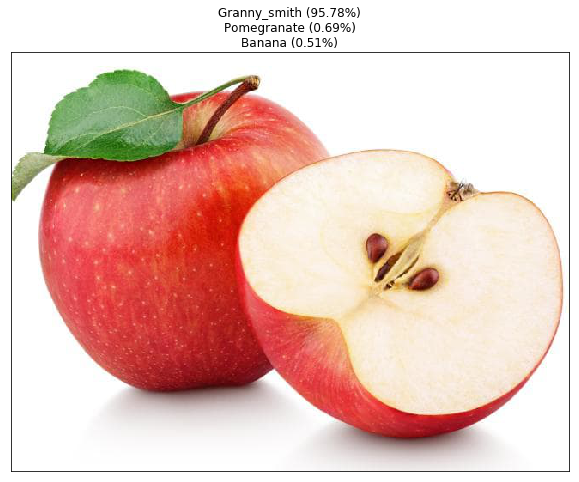

In [28]:
predict_image('images/test/test_0002.jpg', 
              incv3, (299, 299), 
              preprocess_input, 
              decode_predictions)

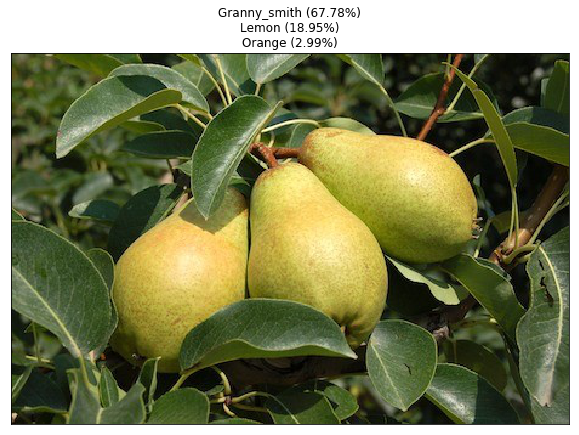

In [29]:
predict_image('images/test/test_0006.jpg', 
              incv3, (299, 299), 
              preprocess_input, 
              decode_predictions)

In [24]:
base_model = InceptionV3(weights='imagenet', include_top=False)

x = base_model.output

x = GlobalAveragePooling2D(name='avg_pool')(x)
x = Dropout(0.4)(x)

x = Dense(1024, activation='relu')(x)
x = Dropout(0.4)(x)

x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)

predictions = Dense(len(LABELS), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
   
for layer in base_model.layers:
    layer.trainable = False
      
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [9]:
WIDTH = 150
HEIGHT = 150
BATCH_SIZE = 16

In [10]:
img_gen_train = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

img_gen_validation = ImageDataGenerator(
    preprocessing_function=preprocess_input)

train_generator = img_gen_train.flow_from_directory(
    TRAIN_DIR,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical')    
validation_generator = img_gen_validation.flow_from_directory(
    VAL_DIR,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

Found 1322 images belonging to 2 classes.
Found 334 images belonging to 2 classes.


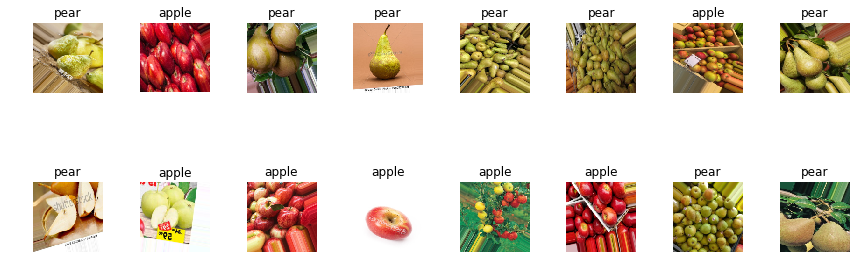

In [11]:
x_batch, y_batch = next(train_generator)
h, w = 4, 8

plt.figure(figsize=(12, 9))
for i, (img, class_probs) in enumerate(zip(x_batch, y_batch)):
    plt.subplot(h, w, i + 1)
    plt.imshow((img + 1) / 2)
    plt.title(LABELS[np.argmax(class_probs)])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [30]:
EPOCHS = 10
tb = TensorBoard(log_dir="logs", write_graph=True, write_images=True)

In [31]:
history = model.fit_generator(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=[tb],
    steps_per_epoch=len(train_generator),
    validation_steps=20)

Epoch 1/10


/usr/lib/python3/dist-packages/PIL/Image.py:918: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/usr/lib/python3/dist-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


83/83 [==============================] - 107s 1s/step - loss: 1.2176 - acc: 0.5815 - val_loss: 1.3229 - val_acc: 0.5094
Epoch 2/10
83/83 [==============================] - 98s 1s/step - loss: 0.6801 - acc: 0.6866 - val_loss: 2.6197 - val_acc: 0.5346
Epoch 3/10
83/83 [==============================] - 95s 1s/step - loss: 0.6333 - acc: 0.6979 - val_loss: 1.8447 - val_acc: 0.5094
Epoch 4/10
83/83 [==============================] - 96s 1s/step - loss: 0.5711 - acc: 0.7325 - val_loss: 0.5249 - val_acc: 0.8176
Epoch 5/10
83/83 [==============================] - 96s 1s/step - loss: 0.6069 - acc: 0.7374 - val_loss: 4.2996 - val_acc: 0.5440
Epoch 6/10
83/83 [==============================] - 96s 1s/step - loss: 0.5291 - acc: 0.7702 - val_loss: 1.6798 - val_acc: 0.5975
Epoch 7/10
83/83 [==============================] - 98s 1s/step - loss: 0.5550 - acc: 0.7676 - val_loss: 0.9132 - val_acc: 0.6226
Epoch 8/10
83/83 [==============================] - 97s 1s/step - loss: 0.5429 - acc: 0.7410 - val_l

In [32]:
model.save('bn_head.hdf5')

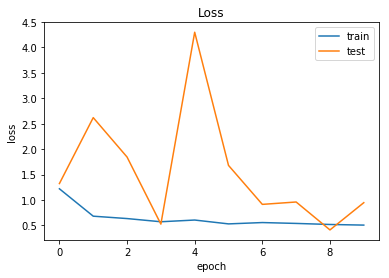

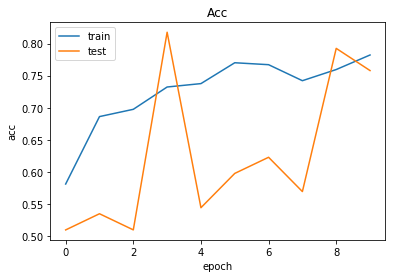

In [33]:
plot_history(history)

In [3]:
model = load_model('bn_head.hdf5')

In [24]:
score = model.evaluate_generator(validation_generator, 
                                 steps=len(validation_generator))

In [25]:
acc = 100 * score[1]
print('Model val accuracy: %0.3f%%' % acc)

Model val accuracy: 76.048%


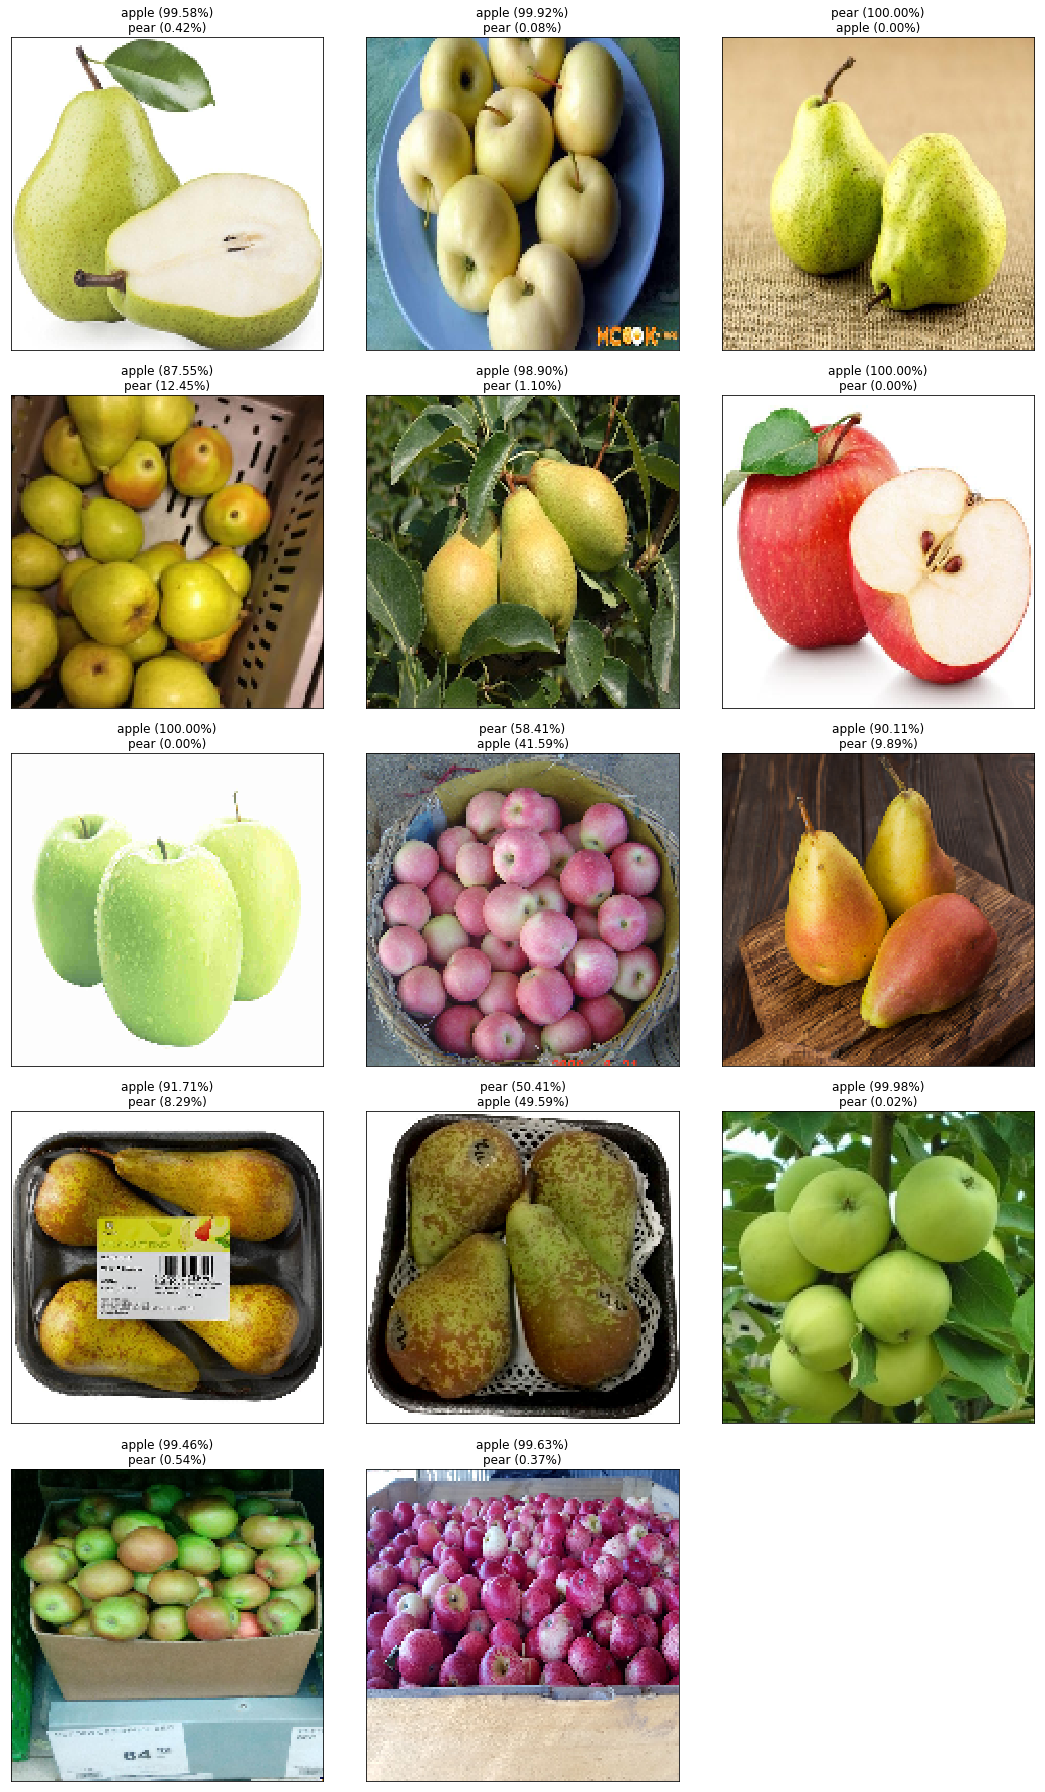

In [26]:
predict_test_images(model)

In [37]:
tb = TensorBoard(log_dir="logs", write_graph=True, write_images=True)

for layer in model.layers[:249]:
    layer.trainable = False
for layer in model.layers[249:]:
    layer.trainable = True

model.compile(optimizer=SGD(lr=1e-4, momentum=0.9), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [38]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=2 * len(train_generator),
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[tb])

Epoch 1/10
166/166 [==============================] - 255s 2s/step - loss: 0.4489 - acc: 0.7980 - val_loss: 0.5483 - val_acc: 0.7844
Epoch 2/10
166/166 [==============================] - 257s 2s/step - loss: 0.3897 - acc: 0.8175 - val_loss: 0.4587 - val_acc: 0.8050
Epoch 3/10
166/166 [==============================] - 242s 1s/step - loss: 0.3872 - acc: 0.8321 - val_loss: 0.4876 - val_acc: 0.8113
Epoch 4/10
166/166 [==============================] - 275s 2s/step - loss: 0.3652 - acc: 0.8270 - val_loss: 0.5717 - val_acc: 0.7987
Epoch 5/10
166/166 [==============================] - 280s 2s/step - loss: 0.3450 - acc: 0.8559 - val_loss: 0.4086 - val_acc: 0.8239
Epoch 6/10
166/166 [==============================] - 288s 2s/step - loss: 0.3312 - acc: 0.8572 - val_loss: 0.4844 - val_acc: 0.8585
Epoch 7/10
166/166 [==============================] - 277s 2s/step - loss: 0.3460 - acc: 0.8536 - val_loss: 0.4050 - val_acc: 0.8522
Epoch 8/10
166/166 [==============================] - 267s 2s/step - 

In [39]:
model.save('bn_unfreezed_head.hdf5')

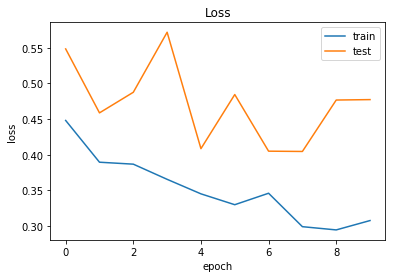

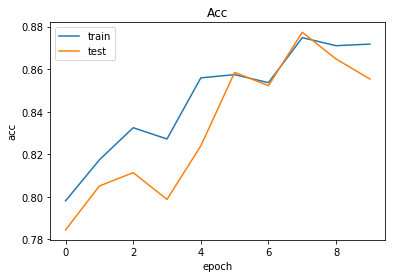

In [40]:
plot_history(history)

In [4]:
model = load_model('bn_unfreezed_head.hdf5')

In [28]:
score = model.evaluate_generator(validation_generator, 
                                 steps=len(validation_generator))

In [29]:
acc = 100 * score[1]
print('Model val accuracy: %0.3f%%' % acc)

Model val accuracy: 86.228%


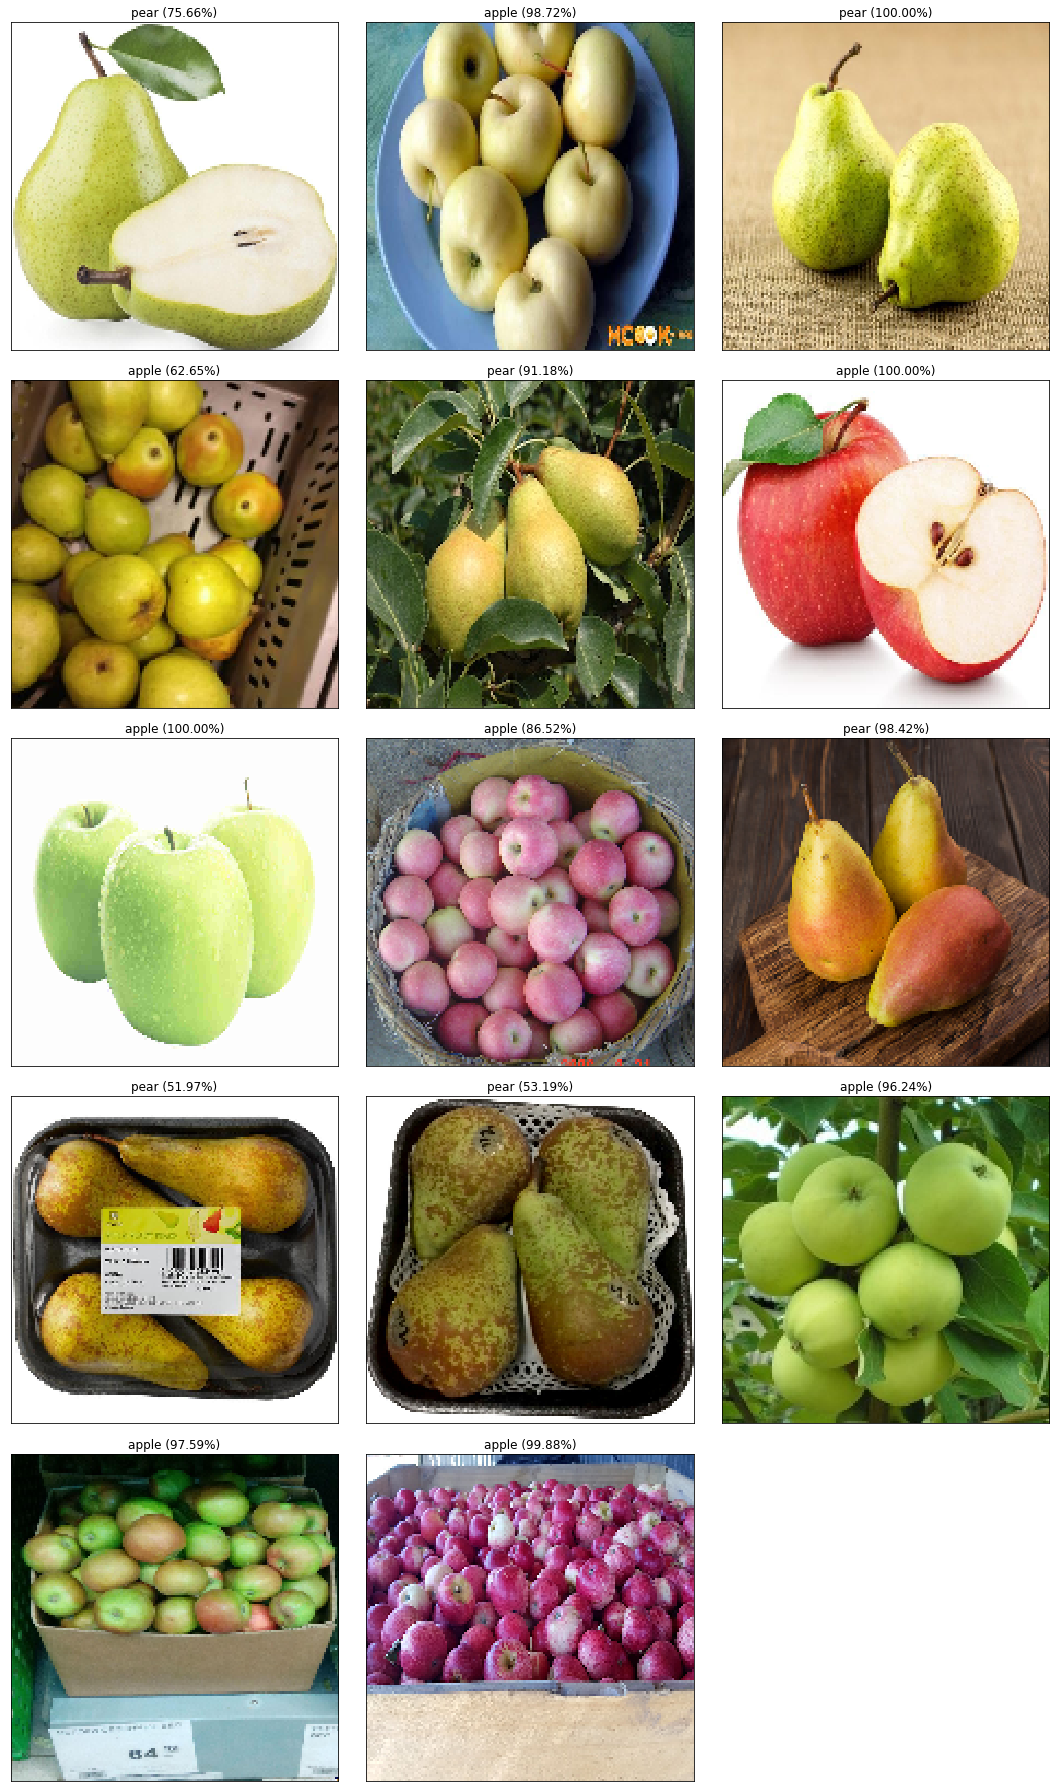

In [25]:
predict_test_images(model)

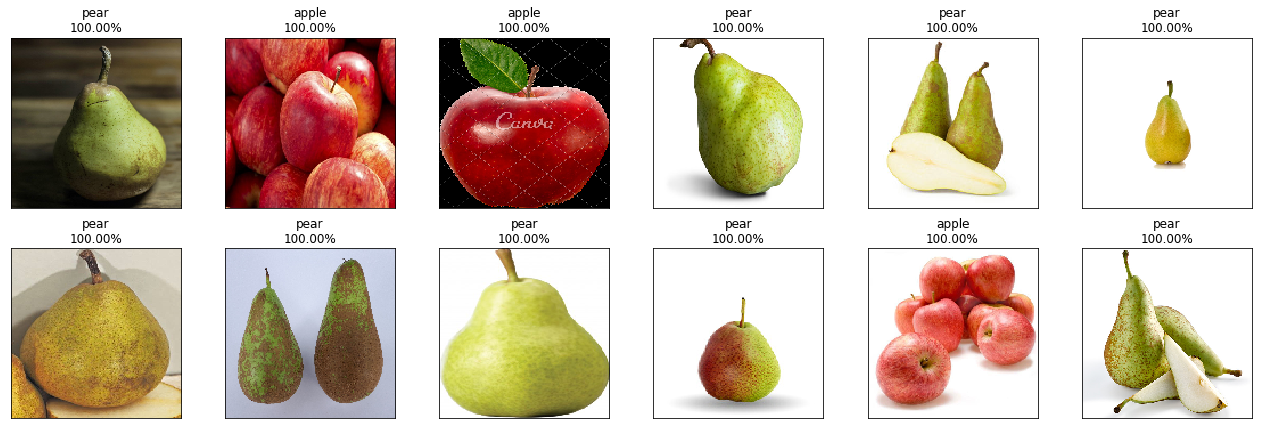

In [15]:
show_most_confident_predictions(validation_generator, model, h=2, w=6)

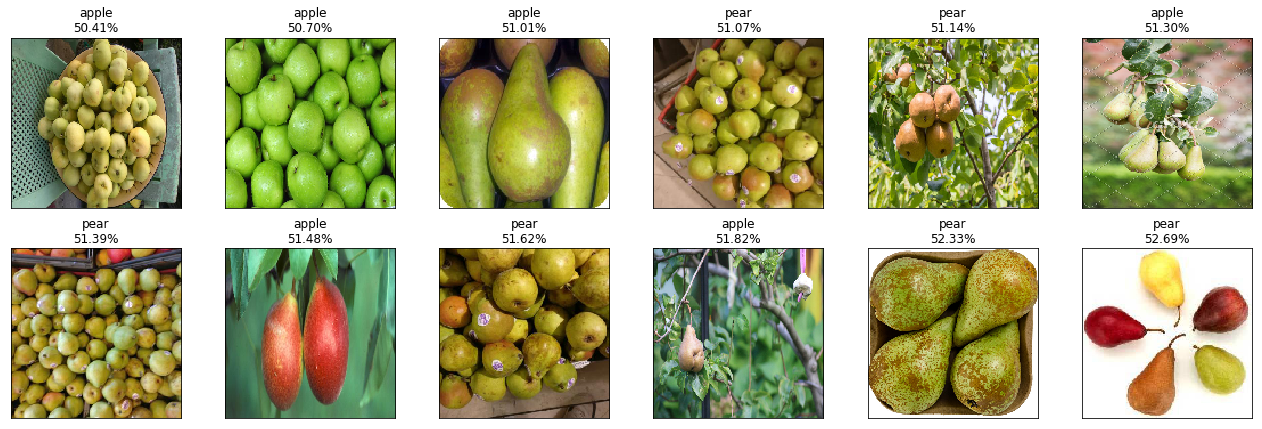

In [17]:
show_most_confident_predictions(validation_generator, model, h=2, w=6, reverse=True)